# Physics 201 Test Notebook

Authors: Vinothan N. Manoharan, with contributions from Solomon Barkley.

## Introduction

Once you've followed our instructions to install python and the packages you need for the course, you can execute the cells in this notebook to test whether your installation is working.  Make sure you run all the cells in order.  Also make sure you are running the notebook in the python environment you set up specifically for Physics 201.

Don't worry if you don't understand what the code does&mdash;at this stage, you're not expected to. You will learn it all by the end of the course!

## Check that all packages import correctly

The following import statements load all of the packages that are required for the homeworks.  This cell should execute without any errors. 

In [1]:
# numpy and scipy. We usually import only submodules of scipy
# since the whole package is big.
import numpy as np
from scipy import stats
import scipy.integrate as integrate
from scipy.special import erf

# pandas: for working with structured data
import pandas as pd
# xarray: labelled multidimensional arrays
import xarray as xr

# plotting packages.  matplotlib is the standard package for 
# plotting with numpy.  seaborn produces statistical plots.
# arviz is used for plotting results from MCMC sampling.
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Markov-chain Monte Carlo (MCMC) samplers.  pymc has several 
# dependencies that might take a little while to load. 
# emcee is another sampler that we will use for specific purposes.
import pymc as pm
import emcee

If you get a warning that reads
```
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
```

you can safely ignore it if the pymc section of this notebook executes properly (and doesn't take forever to run). 

If you've installed the environment for newer Macs running Apple Silicon (the M1 chip) you might get a warning that says
```
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
```
You can ignore this warning if running `conda info` reports `platform: osx-arm64`.  If you get this warning in any other situation please let us know.

The code below checks the version of the `emcee` package.  It should output `2.2.1`.  This is the last version of the code that includes thermodynamic integration, which we use for model comparison:

In [2]:
print(emcee.__version__)

2.2.1


## Test inline graphics

Plots should display inline (directly below the cell you used) by default in all recent versions of python/matplotlib/jupyter. 

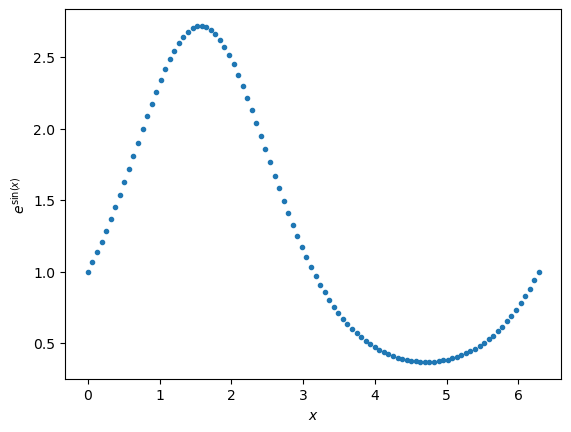

In [3]:
x = np.linspace(0,2*np.pi,100)
y = np.exp(np.sin(x))
plt.plot(x,y, '.')
plt.xlabel('$x$')
plt.ylabel('$e^{\sin(x)}$');

If you didn't see a plot doesn't show up directly in your notebook (or a window popped up instead), run
```
%matplotlib inline
```
and try plotting again.  This line should not be needed, so if you do need to include it, please let us know so that we can figure out what went wrong.

## Testing `pymc` for nonlinear fitting



The next cell contains some data that we'll use for testing.


In [4]:
# Data from Gregory, Bayesian Logical Data Analysis for the 
# Physical Sciences (Cambridge University Press, 2010),
# Table 11.1. Each voltage measurement has an
# uncertainty of 0.3 voltage units.
data11_1 = pd.DataFrame({ 'f': [1,1.17,1.34,1.51,1.68,1.85,2.02,2.19,2.36,
                                2.53,2.7,2.87,3.04,3.21,3.38,3.55,3.72,3.89,
                                4.06,4.23,4.4,4.57,4.74,4.91,5.08,5.25,5.42,
                                5.59,5.76,5.93,6.1,6.27,6.44,6.61,6.78,6.95,
                                7.12,7.29,7.46,7.63,7.8,7.97,8.14,8.31,8.48,
                                8.65,8.82,8.99,9.16,9.33,9.5,9.67,9.84,10.01,
                                10.18,10.35,10.52,10.69,10.86,11.03,11.2,
                                11.37,11.54,11.71,11.88,12.05,12.22,12.39,
                                12.56,12.73,12.9,13.07,13.24,13.41,13.58,
                                13.75,13.92,14.09,14.26,14.43,14.6,14.77,
                                14.94,15.11,15.28,15.45,15.62,15.79,15.96,
                                16.13,16.3,16.47,16.64,16.81,16.98,17.15,
                                17.32,17.49,17.66,17.83],
                          'V': [1.391,1,0.552,1.249,0.534,1.386,0.971,0.901,
                                0.851,1.334,0.549,1.373,0.997,1.231,1.586,2.244,
                                1.914,2.467,2.609,3.036,3.581,4.073,5.01,4.989,
                                4.94,5.537,6.091,6.163,5.365,5.916,5.53,4.552,
                                3.833,3.756,3.055,3.009,2.855,2.357,2.732,1.836,
                                1.918,1.534,2.238,2.623,2.275,2.408,2.701,2.659,
                                3.224,2.237,3.113,3.293,3.139,2.84,3.119,3.311,
                                4.347,4.819,4.378,4.544,4.562,5.662,4.479,5.373,
                                4.883,4.678,5.1,3.868,4.132,3.702,3.267,3.323,
                                3.413,2.762,2.418,2.038,2.585,2.492,2.193,1.866,
                                1.571,1.779,1.542,1.562,1.666,0.904,1.074,1.53,
                                0.747,0.945,1.301,1.323,0.919,1.32,0.915,0.814,
                                0.983,1.158,0.917,1.355]})
uncertainty = 0.3

The next cell sets up a statistical model in pymc.  This cell could take a minute to run.  What's happening behind the scenes is that the code is getting compiled so that it can execute more quickly.  Again, don't worry if you don't understand all of this.  We need to test this process because what happens behind the scenes depends on your computer operating system (Windows, MacOS, Linux) and architecture (Intel or ARM processor).  If you get any errors, let us know, and we will investigate.

In [5]:
sigma_L = 1.0

# reshape data so it behaves when pymc tests multiple parameter values at once
x = data11_1['f'].values[:, np.newaxis]
y = data11_1['V'].values[:, np.newaxis]

peaks_model = pm.Model()
with peaks_model:
    
    # Priors for unknown model parameters
    A0 = pm.Flat('background')
    A1 = pm.Flat('peak_height')
    C1 = pm.Flat('peak_position')

    # Expected value from theory
    V = pm.Deterministic('prediction', A0 + A1 * np.exp(-(x - C1)**2 / (2 * sigma_L**2)))

    # Likelihood of observations
    measurements = pm.Normal('voltage', mu=V, sigma=uncertainty, observed=y)

If the cell above executed without any errors, the next one should work as well.  It may also take a few seconds to run.  A progress bar should appear below the cell.

In [6]:
initial_guess = {'background':0, 'peak_height':1, 'peak_position':5}
best_fit, scipy_output = pm.find_MAP(model=peaks_model, start = initial_guess, return_raw=True)
covariance_matrix = np.flip(scipy_output.hess_inv.todense()/uncertainty)
print(covariance_matrix)


[[ 0.05092233  0.06354062 -0.04855077]
 [ 0.06354062  0.15561616 -0.07771911]
 [-0.04855077 -0.07771911  0.05534292]]


If everything worked, when you execute the next cell you should see a plot of the data in blue and a Gaussian function (in black) that lines up with the first peak in the data.

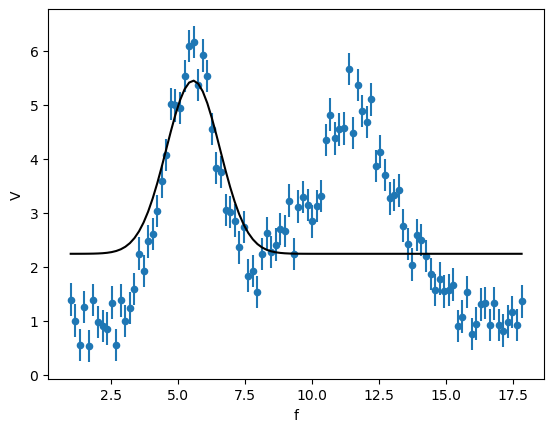

In [7]:
data11_1.plot(x='f', y='V', kind='scatter', yerr=uncertainty)
plt.plot(x, best_fit['prediction'], '-k');

## Testing `emcee`

The next few cells set up a linear fit.  Execute them all in order.

In [8]:
# Data for linear fit from Hogg, Bovy, Lang. "Data Analysis Recipes: 
# Fitting a Model to Data." ArXiv:1008.4686, 2010. 
# http://arxiv.org/abs/1008.4686

dataHBL = pd.DataFrame({ 'x': [201, 244, 47, 287, 203, 58, 210, 202, 198, 158,
                               165, 201, 157, 131, 166, 160, 186, 125, 218, 146],
                         'y': [592, 401, 583, 402, 495, 173, 479, 504, 510, 416,
                               393, 442, 317, 311, 400, 337, 423, 334, 533, 344],
                         'sigma_y': [61, 25, 38, 15, 21, 15, 27, 14, 30, 16,
                                     14, 25, 52, 16, 34, 31, 42, 26, 16, 22],
                         'sigma_x': [9, 4, 11, 7, 5, 9, 4, 4, 11, 7,
                                     5, 5, 5, 6, 6, 5, 9, 8, 6, 5],
                         'rho_xy': [-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56]})

In [9]:
x = dataHBL['x'][4:]
y = dataHBL['y'][4:]
sigma_y = dataHBL['sigma_y'][4:]

In [10]:
def log_prior(theta):
    """
    returns log of prior probability distribution
    
    Parameters:
        theta: model parameters (specified as a tuple)
    """
    # unpack the model parameters
    m, b = theta
  
    # we don't have to explicitly normalize our prior
    return 0
    
def log_likelihood(theta, x, y, sigma_y):
    """
    returns log of likelihood
    
    Parameters:
        theta: model parameters (specified as a tuple)
        x: independent data (array of length N)
        y: measurements (array of length N)
        sigma_y: uncertainties on y (array of length N)
    """
    m, b = theta
    residual = (y - m*x - b)**2
    chi_square = np.sum(residual/(sigma_y**2))
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sigma_y**2)))
    return constant - 0.5*chi_square

def log_posterior(theta, x, y, sigma_y):
    """
    returns log of posterior probability distribution
    
    Parameters:
        theta: model parameters (specified as a tuple)
        x: independent data (array of length N)
        y: measurements (array of length N)
        sigma_y: uncertainties on y (array of length N)
    """
    m, b = theta
    return log_prior(theta) + log_likelihood(theta, x, y, sigma_y)

In [11]:
# the model has 2 parameters; we'll use 50 walkers and 500 steps each
ndim = 2
nwalkers = 50
nsteps = 500

ls_result = [2.24, 34] # from HBL figure 1
gaussian_ball = 1e-4 * np.random.randn(nwalkers, ndim)
starting_positions = (1 + gaussian_ball) * ls_result

The following cell starts the sampler to do the fit.  Sampling should take not take too much longer than a minute.  The total time will depend on how fast your computer is and what else is running on it.

In [12]:
# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(x, y, sigma_y))
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: total: 38.5 s
Wall time: 38.8 s
Done


In [13]:
samples = sampler.chain[:,100:,:]
# reshape the samples into a 1D array where the colums are m and b
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels.  This will come in handy 
# in a moment, when we start using seaborn to plot our results 
# (among other things, it saves us the trouble of typing in labels
# for our plots)
parameter_samples = pd.DataFrame({'m': traces[0], 'b': traces[1]})

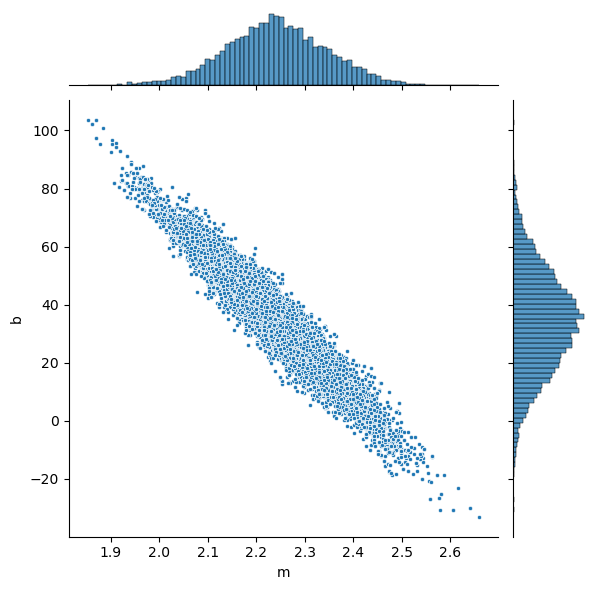

In [14]:
sns.jointplot(parameter_samples, x='m', y='b', marker='.')

Results from executing the next cell should be close to
$$ m = 2.24 \pm 0.11 $$
$$ b = 34 \pm 18 $$

In [15]:
# calculating the MAP and values can be done concisely using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("m = {:.2f} + {:.2f} - {:.2f}".format(q['m'][0.50], 
                                            q['m'][0.84]-q['m'][0.50],
                                            q['m'][0.50]-q['m'][0.16]))
print("b = {:.1f} + {:.1f} - {:.1f}".format(q['b'][0.50], 
                                            q['b'][0.84]-q['b'][0.50],
                                            q['b'][0.50]-q['b'][0.16]))

m = 2.24 + 0.11 - 0.10
b = 34.1 + 17.3 - 17.8


## Testing NUTS sampling in `pymc`

Now we'll test `pymc` again, this time using its powerful NUTS sampler.  Again, it should take a few seconds to execute the next cell.  Behind the scenes, the code is getting compiled.

In [16]:
x = dataHBL['x'][4:]
y = dataHBL['y'][4:]
sigma_y = dataHBL['sigma_y'][4:]

In [17]:
linear_model = pm.Model()

with linear_model:

    # For the prior, I'll use a uniform (improper) prior on both m and b.
    # You can choose from several other distributions for the prior;
    # see 
    m = pm.Flat('m') 
    b = pm.Flat('b')

    # Now I need to define the linear model.  "mu" is the expected value
    # from the model
    mu = m*x + b

    # Finally, I define the likelihood (sampling distribution) of the observations
    # I have to use sigma_y.values here because pymc can't handle
    # a pandas Series object here, only a numpy array
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_y.values, observed=y)

The following cell will test whether `pymc` can output a graphical representation of its model.  This tests whether `python-graphviz` is installed and working correctly.  If this doesn't work, it's not a dealbreaker.

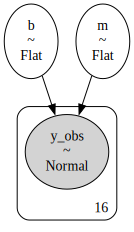

In [18]:
pm.model_to_graphviz(linear_model)

Running the following cell starts the sampler.  It should take a minute or less to sample.  You might get a warning saying &ldquo;The acceptance probability does not match the target&rdquo; and/or &ldquo;The number of effective samples is smaller than 25% for some parameters.&rdquo; You can ignore these warnings.

In [19]:
with linear_model:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 36 seconds.


The plot produced by the following cell should look similar to the one produced by `emcee` in the previous section.

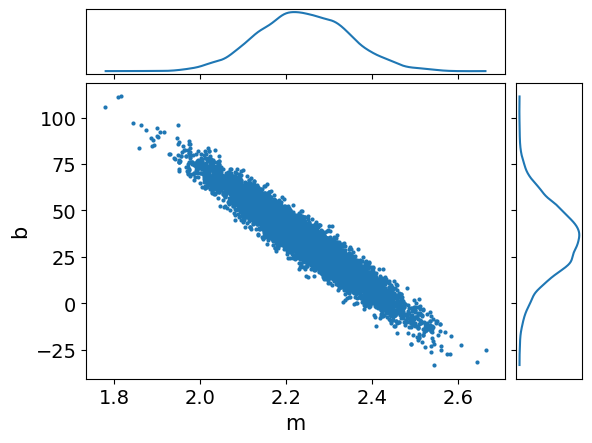

In [20]:
az.plot_pair(idata, marginals=True);

Again, the results reported by the next cell should be close to
$$ m = 2.24 \pm 0.11 $$
$$ b = 34 \pm 18 $$

In [21]:
q = idata.posterior.quantile([0.16,0.50,0.84], dim=('chain', 'draw'))
print("m = {:.2f} + {:.2f} - {:.2f}".format(q.sel(quantile=0.50)['m'], 
                                            q.sel(quantile=0.84)['m']-q.sel(quantile=0.50)['m'],
                                            q.sel(quantile=0.50)['m']-q.sel(quantile=0.16)['m']))
print("b = {:.1f} + {:.1f} - {:.1f}".format(q.sel(quantile=0.50)['b'], 
                                            q.sel(quantile=0.84)['b']-q.sel(quantile=0.50)['b'],
                                            q.sel(quantile=0.50)['b']-q.sel(quantile=0.16)['b']))


m = 2.24 + 0.11 - 0.10
b = 34.4 + 17.9 - 17.9


## Next steps

If all the cells executed OK, you are all set for the rest of the course (at least until the final project)!  If not, report any errors to the course staff or file an issue on GitHub.